# Experiment n.2:

In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.signal import find_peaks
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, concatenate, Conv1D, Dense, Dropout, Flatten, MaxPooling1D
from tensorflow.keras import Model

In [2]:
nPastHours = 24
nPastHours2 = 48
nLabels = 1
nFuture = 1
batchSize = 16
epochs = 30
epochs2 = 100
patience = 2

In [3]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience, mode='min')

In [4]:
plt.rcParams["figure.figsize"] = (12,8)

## Importing datasets

In [5]:
# real data
real_data = pd.read_csv('real_data.csv')
real_data = real_data[['PM10 Concentration', 'PM2.5 Concentration']]

# trend
trend = pd.read_csv('trend_cleaned.csv')
trend = trend[['PM10 Concentration', 'PM2.5 Concentration']]

# trend + seasonal
trend_seasonal = pd.read_csv('trend_seasonal_cleaned.csv')

array([<AxesSubplot: >, <AxesSubplot: >], dtype=object)

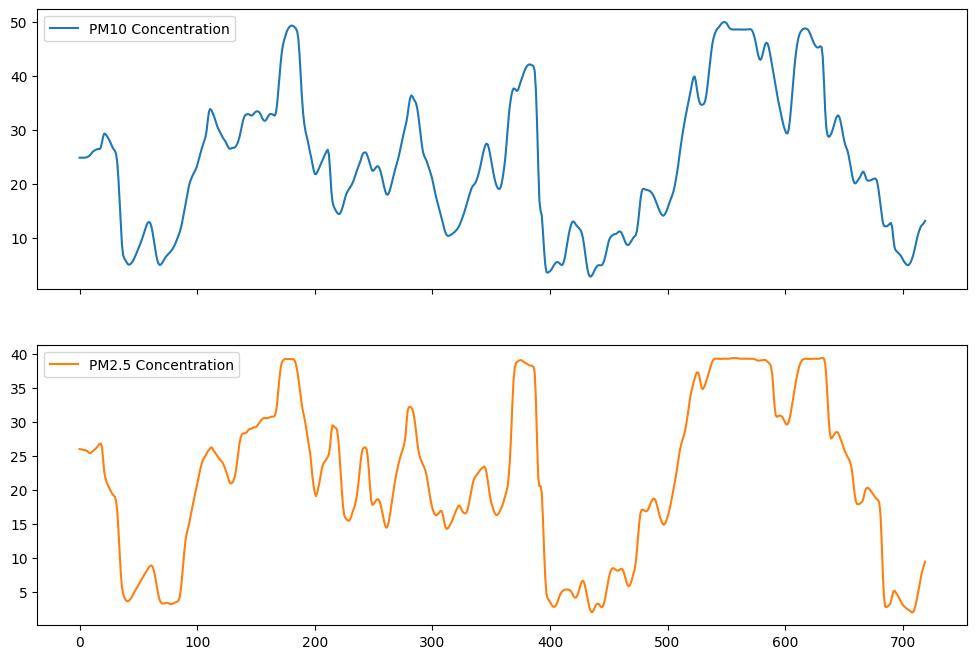

In [6]:
trend[:720].plot(subplots=True)

array([<AxesSubplot: >, <AxesSubplot: >], dtype=object)

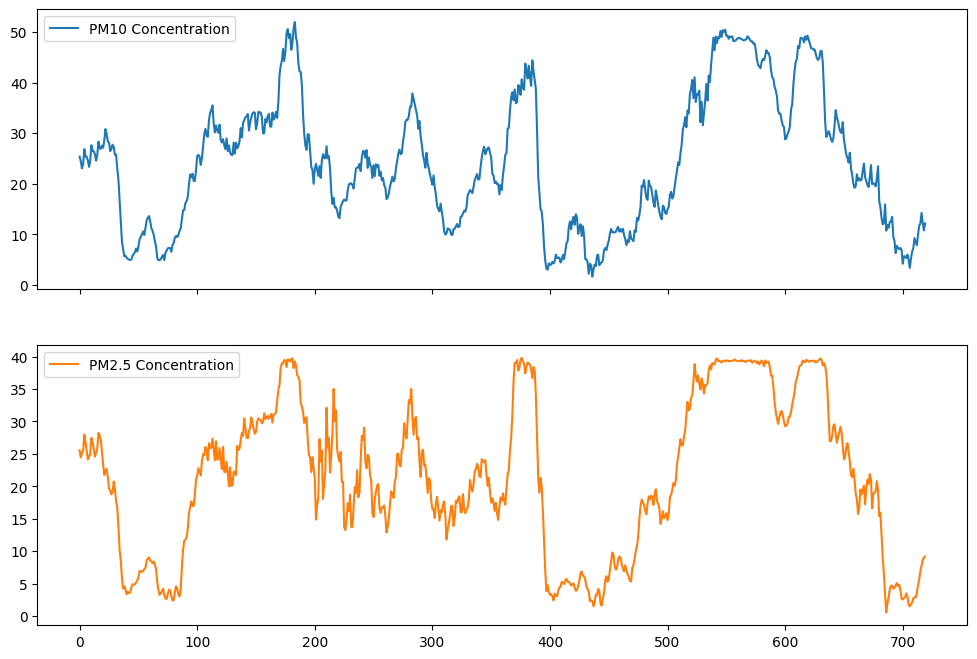

In [7]:
trend_seasonal[:720].plot(subplots=True)

array([<AxesSubplot: >, <AxesSubplot: >], dtype=object)

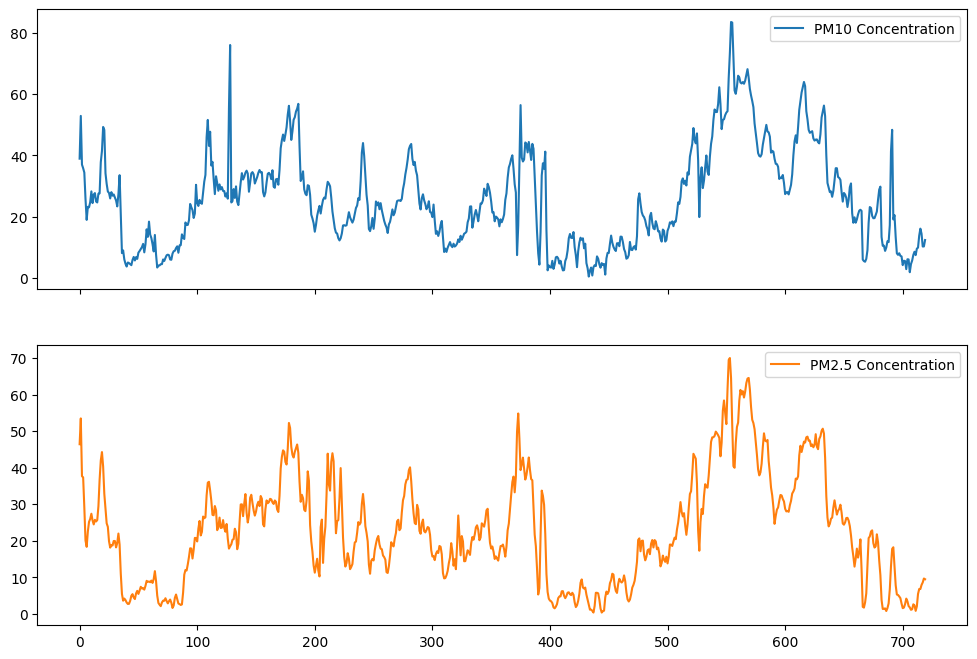

In [8]:
real_data[:720].plot(subplots=True)

### Data scaling

In [9]:
trend_scaler = MinMaxScaler()
trend_seasonal_scaler = MinMaxScaler()

trend = trend_scaler.fit_transform(trend)
trend_seasonal = trend_seasonal_scaler.fit_transform(trend_seasonal)

### Data windowing

In [10]:
trainData = trend[0:int(len(trend)*0.8), :]
testData = trend[int(len(trend)*.8):, :]

trainX = []
trainY = []

for i in range(nPastHours, len(trainData) - nFuture + 1):
    trainX.append(trainData[i - nPastHours: i, 0: trainData.shape[1]])
    trainY.append(trainData[i + nFuture - 1: i + nFuture, :]) # PM10 je zvoleny ako y label

trainX = np.array(trainX)
trainY = np.array(trainY)
trainY = trainY.squeeze()
print(f'trainX shape: {trainX.shape}; trainY shape: {trainY.shape}')

testX = []
for i in range(nPastHours, len(testData)):
    testX.append(testData[i-nPastHours: i, 0: testData.shape[1]])

testX = np.array(testX)
print(f'testX shape: {testX.shape}')

trainX shape: (21020, 24, 2); trainY shape: (21020, 2)
testX shape: (5237, 24, 2)


## Model n.1

In [11]:
model1 = tf.keras.Sequential([
    Input(shape=(trainX.shape[1], trainX.shape[2])),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(units=32, activation='relu'),
    Dropout(0.2),
    Dense(units=16, activation='relu'),
    Dense(units=2)
])
model1.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.RootMeanSquaredError(),
            tf.keras.metrics.MeanAbsolutePercentageError()
        ]
    )
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 64)            320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 11, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 64)            8256      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 320)               0

In [12]:
history = model1.fit(trainX, trainY, epochs=epochs, batch_size=batchSize, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/30
1183/1183 [==============================] - 4s 3ms/step - loss: 0.0130 - mean_absolute_error: 0.0761 - root_mean_squared_error: 0.1141 - mean_absolute_percentage_error: 29.3344 - val_loss: 0.0112 - val_mean_absolute_error: 0.0798 - val_root_mean_squared_error: 0.1056 - val_mean_absolute_percentage_error: 51937.4961
Epoch 2/30
1183/1183 [==============================] - 3s 2ms/step - loss: 0.0054 - mean_absolute_error: 0.0519 - root_mean_squared_error: 0.0734 - mean_absolute_percentage_error: 20.8101 - val_loss: 0.0071 - val_mean_absolute_error: 0.0618 - val_root_mean_squared_error: 0.0841 - val_mean_absolute_percentage_error: 47727.2852
Epoch 3/30
1183/1183 [==============================] - 3s 2ms/step - loss: 0.0040 - mean_absolute_error: 0.0446 - root_mean_squared_error: 0.0630 - mean_absolute_percentage_error: 17.9437 - val_loss: 0.0076 - val_mean_absolute_error: 0.0638 - val_root_mean_squared_error: 0.0874 - val_mean_absolute_percentage_error: 40632.8359
Epoch 4/30
11

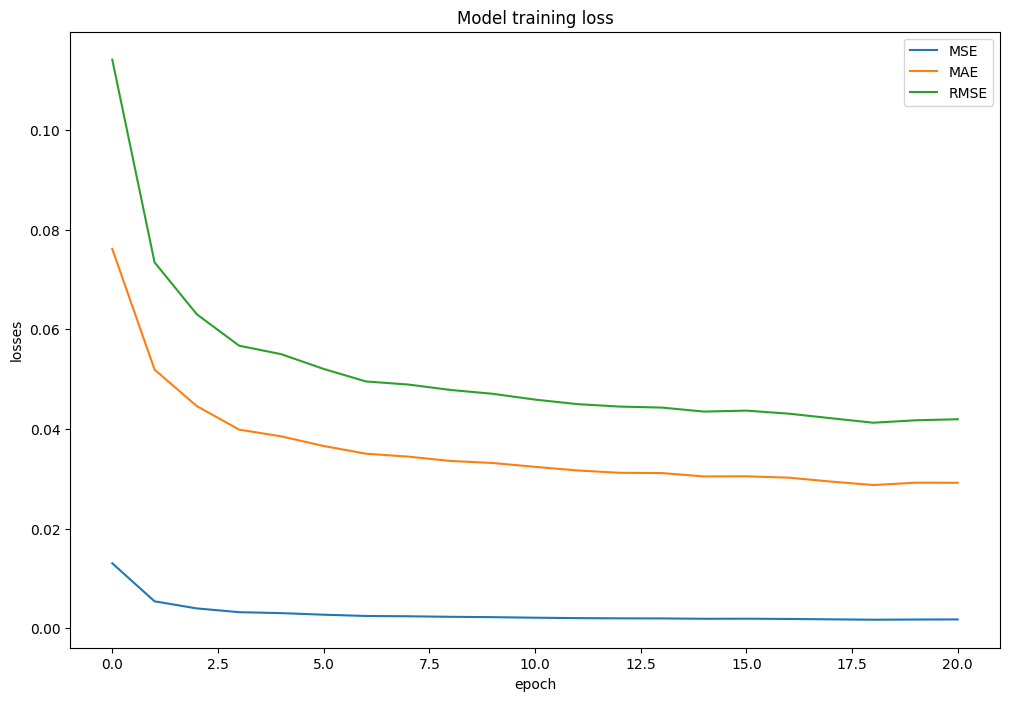

In [13]:
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['mean_absolute_error'], label='MAE')
plt.plot(history.history['root_mean_squared_error'], label='RMSE')
plt.title('Model training loss')
plt.ylabel('losses')
plt.xlabel('epoch')
plt.legend()
plt.show()

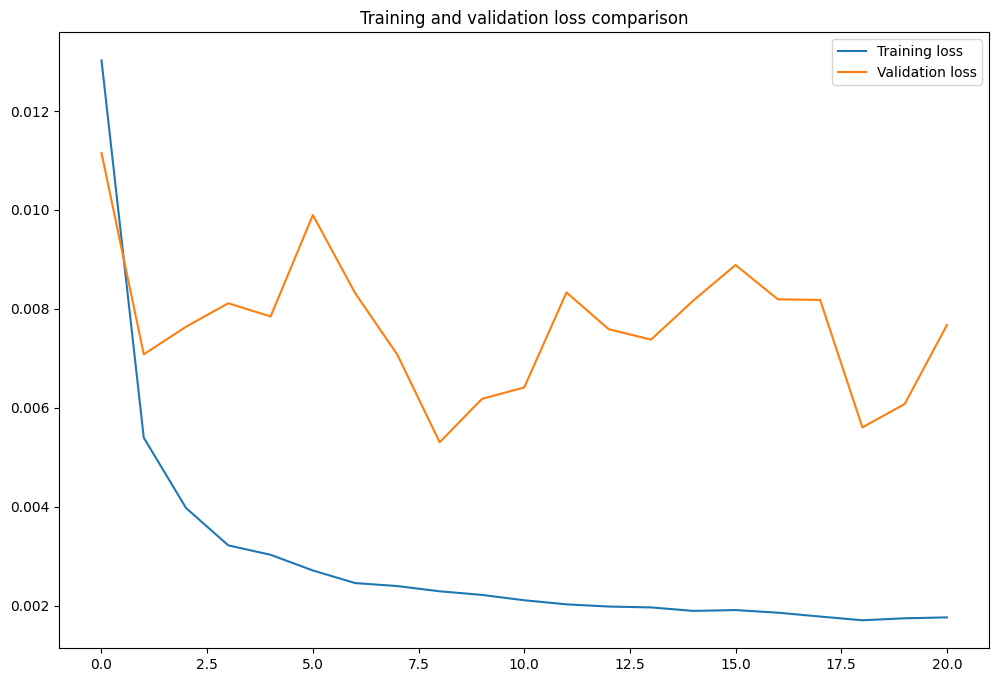

In [14]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss comparison')
plt.legend()

### Model evaluation

In [15]:
def plotAndEvaluate(model, scaler, timeseries, realData, testData, past_hours=200):
    realData = realData[-past_hours:]
    testData = testData[-past_hours:]
    y_pred = model.predict(testX[-past_hours:])
    inv = pd.DataFrame({
        'pm10': y_pred[:, 0],
        'pm2.5': y_pred[:, 1],
    })
    inv = scaler.inverse_transform(inv)

    var1_perc25 = np.percentile(inv[:, 0], 25)
    var2_perc25 = np.percentile(inv[:, 1], 25)

    peaks1, _ = find_peaks(realData[:, 0], width=1)
    peaks2, _ = find_peaks(realData[:, 1], width=1)

    diffs1, diffs2 = [], []
    for x in peaks1:
        if realData[x][0] >= inv[x][0] + var1_perc25:
            diffs1.append(x)
    for x in peaks2:
        if realData[x][1] >= inv[x][1] + var2_perc25:
            diffs2.append(x)

    plt.plot(testData[:, 0], color='#fac516')
    plt.plot(realData[:, 0], color='#0496b0')
    plt.plot(inv[:, 0], color='#fa1616')
    for diff in diffs1:
        plt.axvspan(diff-3, diff+3, facecolor='red', alpha=0.2)
    plt.legend(['Test data', 'Real data', 'Predictions'])
    plt.title('PM10 predictions')
    plt.show()

    plt.plot(testData[:, 1], color='#fac516')
    plt.plot(realData[:, 1], color='#0496b0')
    plt.plot(inv[:, 1], color='#fa1616')
    for diff in diffs2:
        plt.axvspan(diff-3, diff+3, facecolor='red', alpha=0.2)
    plt.legend(['Test data', 'Real data', 'Predictions'])
    plt.title('PM2.5 predictions')
    plt.show()

    metrics = dict()
    metrics['MAPE'] = mean_absolute_percentage_error(inv, realData)
    metrics['RMSE'] = math.sqrt(mean_squared_error(inv, realData))
    metrics['MAE'] = mean_absolute_error(inv, realData)
    return metrics

In [16]:
real_data = real_data[int(len(real_data)*0.8):]
real_data = real_data.to_numpy()

In [17]:
model1_metrics = dict()

### In: Trend (cleaned, normed)

In [18]:
test_data = trend[-200:]
test_data = pd.DataFrame(test_data)
test_data = trend_scaler.inverse_transform(test_data)

7/7 [==============================] - 0s 1ms/step


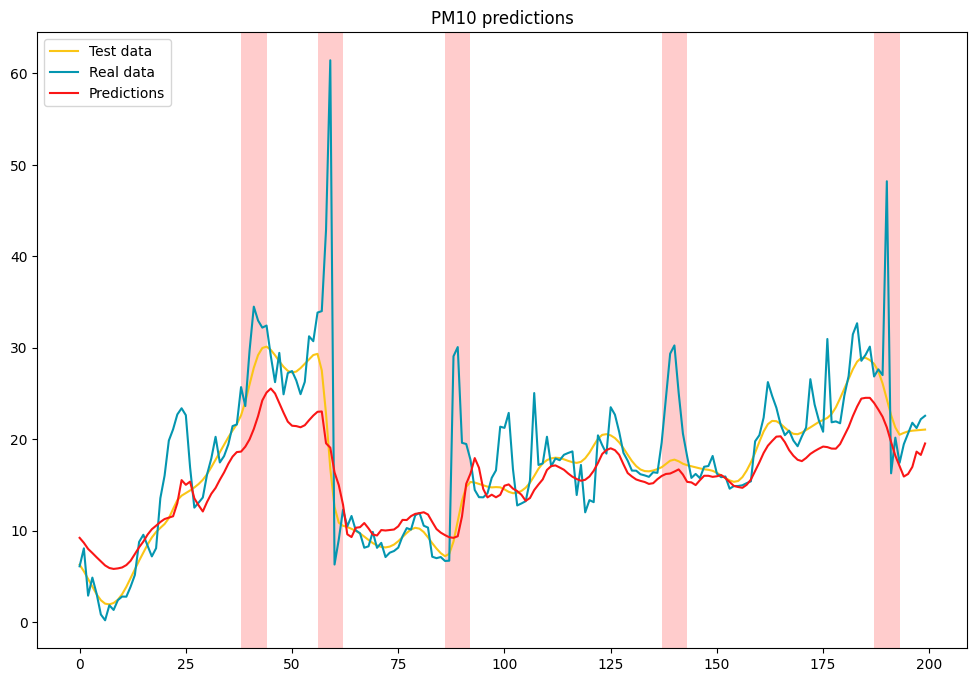

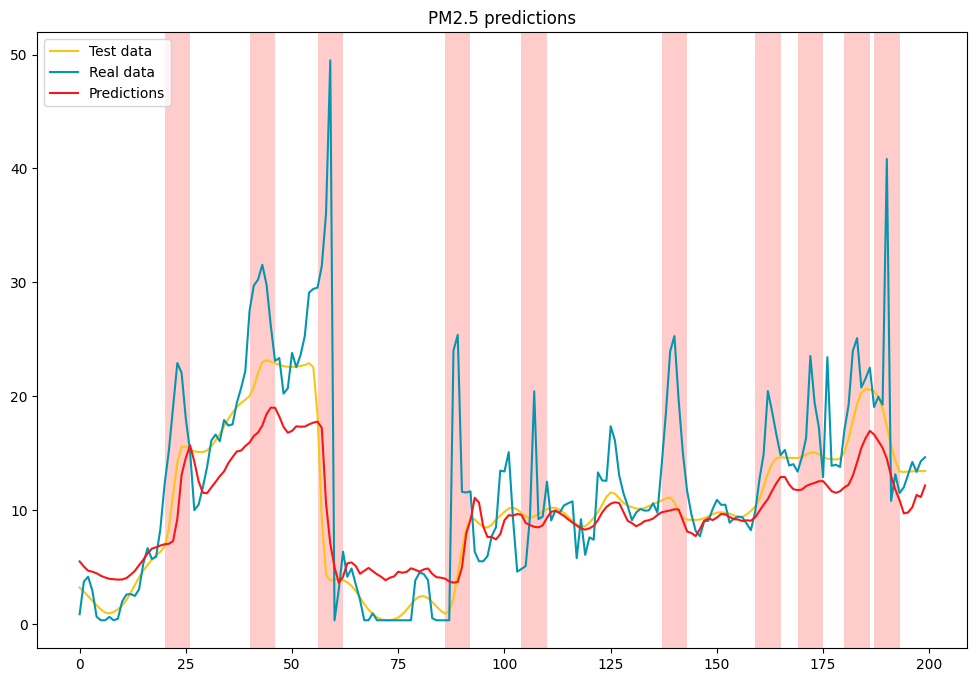

{'trend': {'MAPE': 0.3943590086957466,
  'RMSE': 6.540633204521878,
  'MAE': 4.229522260089416}}

In [19]:
model1_metrics['trend'] = plotAndEvaluate(model1, trend_scaler, testX, real_data, test_data)
model1_metrics

### In: Trend + Seasonal (cleaned, normed)

In [20]:
testData = trend_seasonal[int(len(trend_seasonal)*0.8):]

testX = []
for i in range(nPastHours, len(testData)):
    testX.append(testData[i-nPastHours: i, :])

testX = np.array(testX)
print(f'testX shape: {testX.shape}')

testX shape: (5237, 24, 2)


In [21]:
testData = pd.DataFrame(testData)
testData = trend_seasonal_scaler.inverse_transform(testData)

7/7 [==============================] - 0s 1ms/step


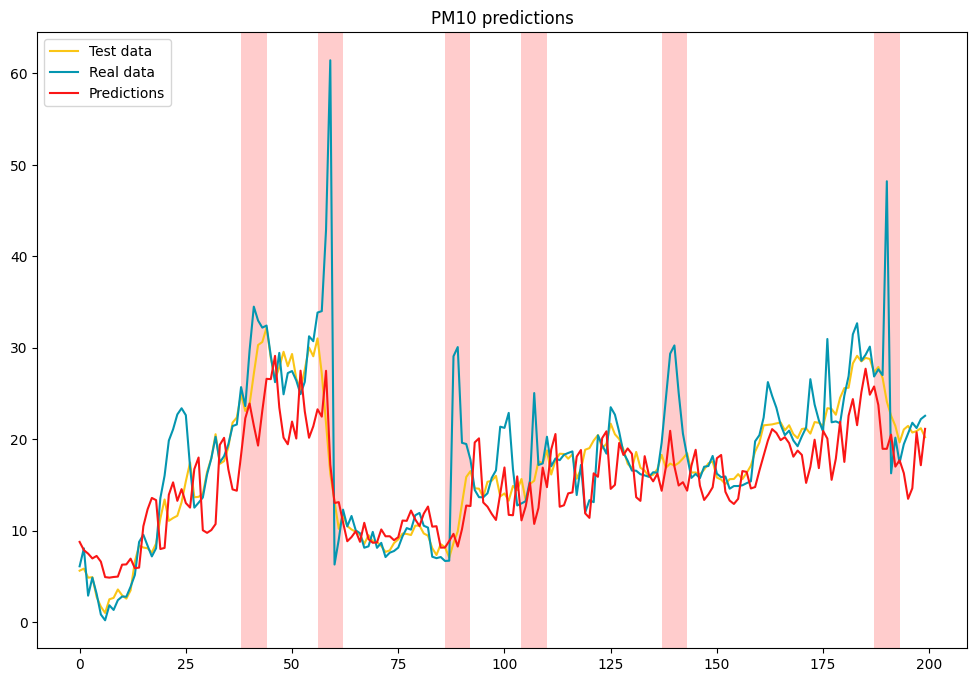

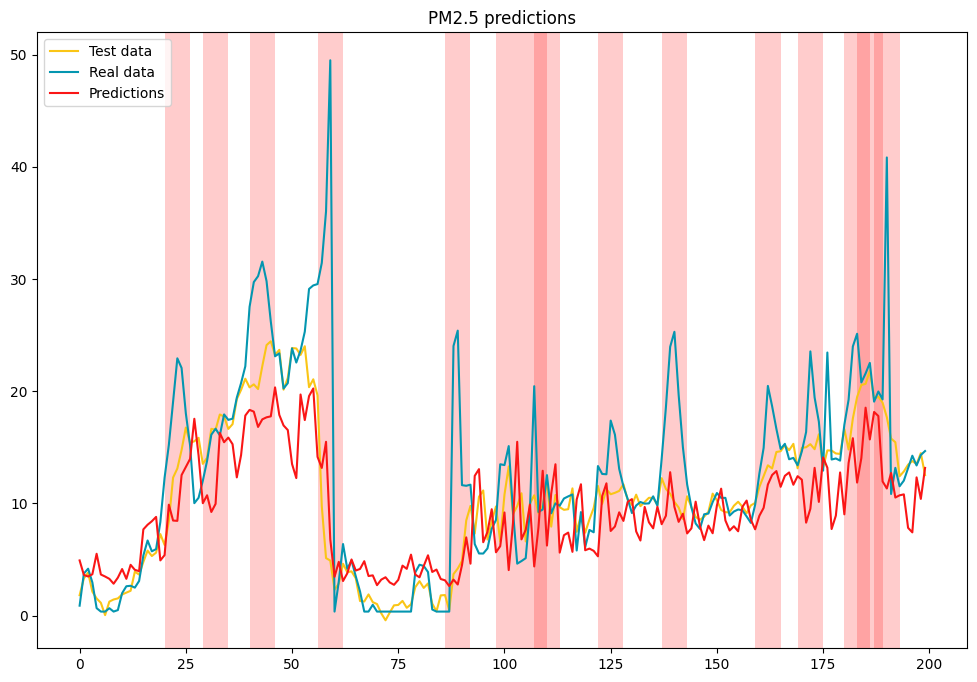

{'trend': {'MAPE': 0.3943590086957466,
  'RMSE': 6.540633204521878,
  'MAE': 4.229522260089416},
 'trend+seasonal': {'MAPE': 0.4877023657763605,
  'RMSE': 6.976640059270456,
  'MAE': 4.775342481812703}}

In [22]:
model1_metrics['trend+seasonal'] = plotAndEvaluate(model1, trend_seasonal_scaler, testX, real_data, testData)
model1_metrics

## Model n.2

In [23]:
trainData = trend[0:int(len(trend)*0.8), :]
testData = trend[int(len(trend)*.8):, :]

X = []
trainY = []

for i in range(nPastHours, len(trainData) - nFuture + 1):
    X.append(trainData[i - nPastHours: i, :])
    trainY.append(trainData[i + nFuture - 1: i + nFuture, :])

X = np.array(X)
trainX1 = X[:, :, 0].reshape(X.shape[0], X.shape[1], 1)
trainX2 = X[:, :, 1].reshape(X.shape[0], X.shape[1], 1)
trainY = np.array(trainY)
trainY = trainY.squeeze()
print(f'trainX1 and trainX2 shape: {trainX1.shape}\ntrainY shape: {trainY.shape}')

testX = []
for i in range(nPastHours, len(testData)):
    testX.append(testData[i-nPastHours: i, 0: testData.shape[1]])

testX = np.array(testX)
print(f'testX shape: {testX.shape}')

trainX1 and trainX2 shape: (21020, 24, 1)
trainY shape: (21020, 2)
testX shape: (5237, 24, 2)


In [24]:
input1 = Input(shape=(nPastHours, 1))
cnn1 = Conv1D(filters=64, kernel_size=2, activation='relu')(input1)
cnn1 = MaxPooling1D(pool_size=2)(cnn1)
cnn1 = Dropout(0.2)(cnn1)
cnn1 = Conv1D(filters=64, kernel_size=2, activation='relu')(cnn1)
cnn1 = MaxPooling1D(pool_size=2)(cnn1)
cnn1 = Flatten()(cnn1)

input2 = Input(shape=(nPastHours, 1))
cnn2 = Conv1D(filters=64, kernel_size=2, activation='relu')(input2)
cnn2 = MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Dropout(0.2)(cnn2)
cnn2 = Conv1D(filters=64, kernel_size=2, activation='relu')(cnn2)
cnn2 = MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Flatten()(cnn2)

merge = concatenate([cnn1, cnn2])
dense = Dense(units=64, activation='relu')(merge)
dropout = Dropout(0.2)(dense)
output = Dense(units=2)(dropout)

model2 = Model(inputs=[input1, input2], outputs=output)

model2.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.RootMeanSquaredError(),
            tf.keras.metrics.MeanAbsolutePercentageError()
        ]
    )
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 24, 1)]      0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 24, 1)]      0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 23, 64)       192         ['input_2[0][0]']                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 23, 64)       192         ['input_3[0][0]']                
                                                                                              

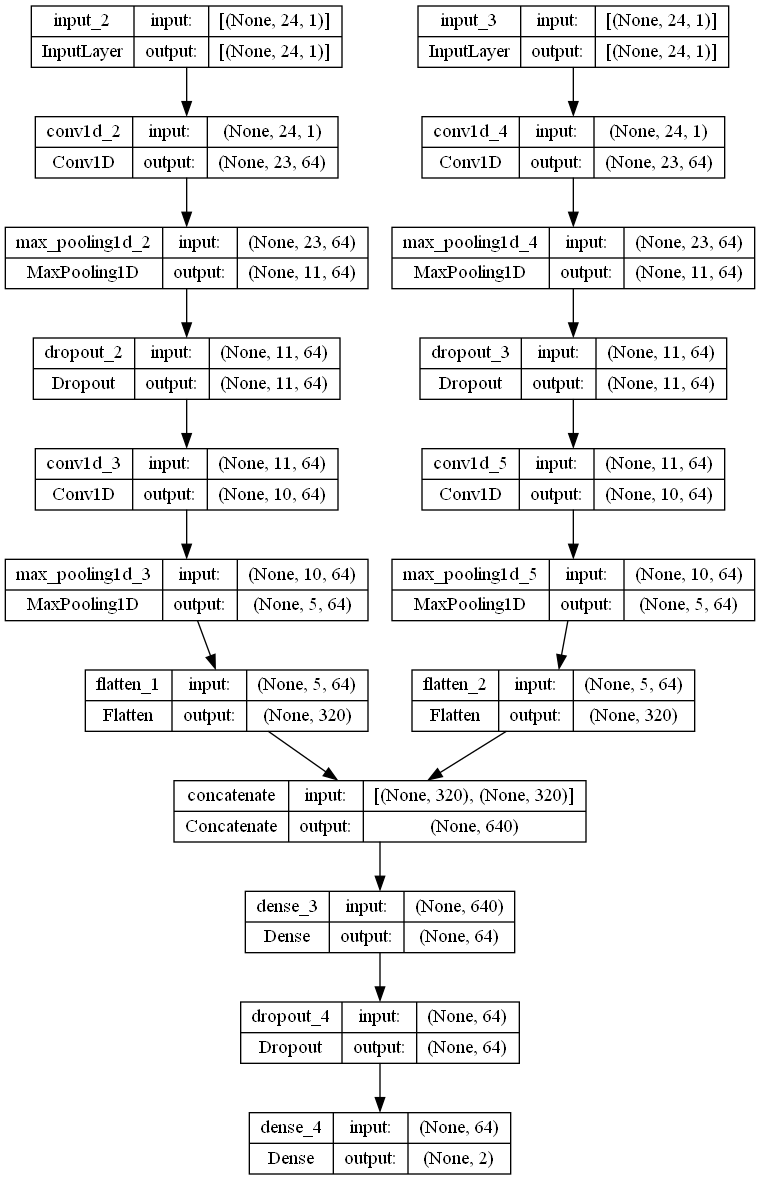

In [25]:
tf.keras.utils.plot_model(model2, show_shapes=True)

In [26]:
history = model2.fit([trainX1, trainX2], trainY, epochs=epochs, batch_size=batchSize, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/30
1183/1183 [==============================] - 4s 3ms/step - loss: 0.0095 - mean_absolute_error: 0.0670 - root_mean_squared_error: 0.0976 - mean_absolute_percentage_error: 24.3222 - val_loss: 0.0068 - val_mean_absolute_error: 0.0624 - val_root_mean_squared_error: 0.0825 - val_mean_absolute_percentage_error: 62980.5742
Epoch 2/30
1183/1183 [==============================] - 3s 3ms/step - loss: 0.0045 - mean_absolute_error: 0.0471 - root_mean_squared_error: 0.0667 - mean_absolute_percentage_error: 18.0586 - val_loss: 0.0027 - val_mean_absolute_error: 0.0368 - val_root_mean_squared_error: 0.0523 - val_mean_absolute_percentage_error: 30652.0488
Epoch 3/30
1183/1183 [==============================] - 3s 3ms/step - loss: 0.0035 - mean_absolute_error: 0.0425 - root_mean_squared_error: 0.0593 - mean_absolute_percentage_error: 16.7808 - val_loss: 0.0046 - val_mean_absolute_error: 0.0524 - val_root_mean_squared_error: 0.0677 - val_mean_absolute_percentage_error: 37194.6484
Epoch 4/30
11

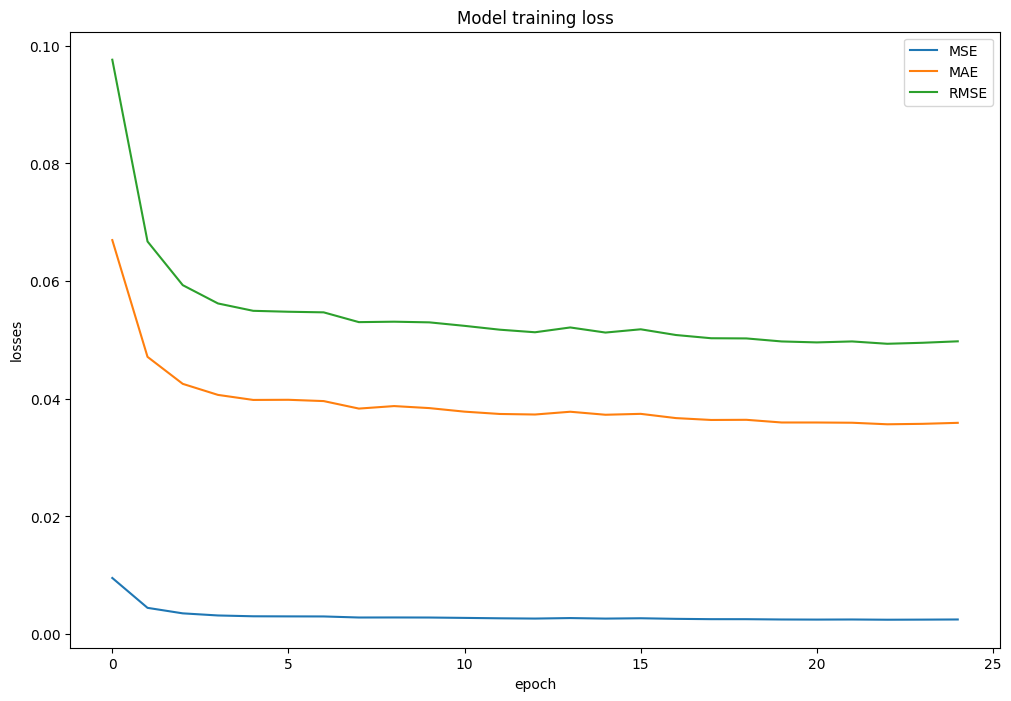

In [27]:
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['mean_absolute_error'], label='MAE')
plt.plot(history.history['root_mean_squared_error'], label='RMSE')
plt.title('Model training loss')
plt.ylabel('losses')
plt.xlabel('epoch')
plt.legend()
plt.show()

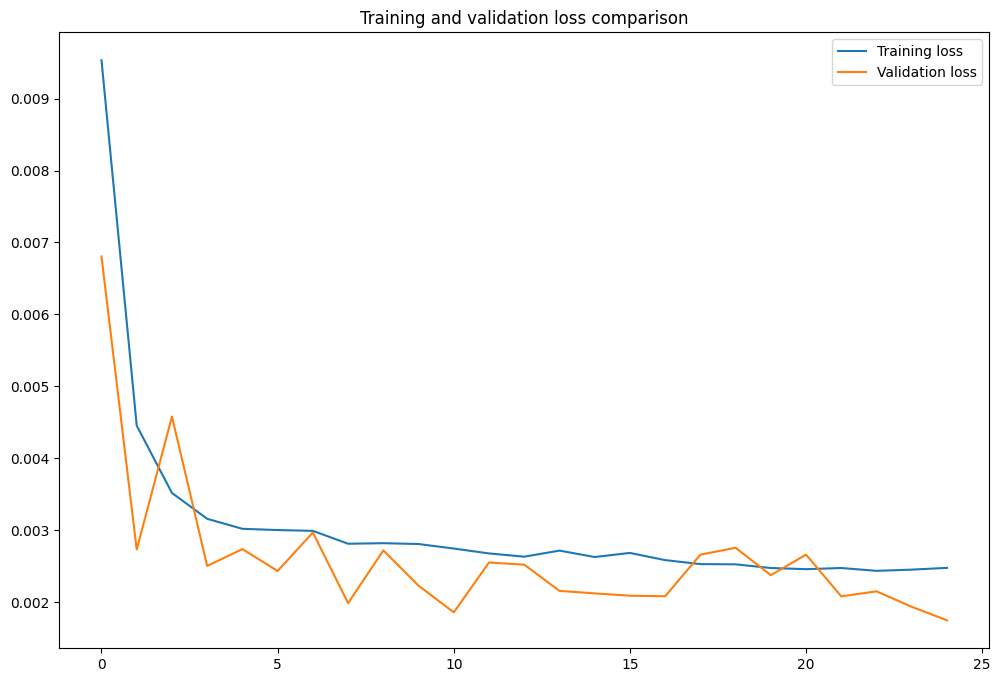

In [28]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss comparison')
plt.legend()

### Model evaluation

In [29]:
def plotAndEvaluateMultiHead(model, scaler, timeseries, realData, testData, past_hours=200):
    realData = realData[-past_hours:]
    testData = testData[-past_hours:]
    X1 = timeseries[:, :, 0].reshape(timeseries.shape[0], timeseries.shape[1], 1)
    X2 = timeseries[:, :, 1].reshape(timeseries.shape[0], timeseries.shape[1], 1)
    y_pred = model.predict([X1[-past_hours:], X2[-past_hours:]])
    inv = pd.DataFrame({
        'pm10': y_pred[:, 0],
        'pm2.5': y_pred[:, 1],
    })
    inv = scaler.inverse_transform(inv)

    var1_perc25 = np.percentile(inv[:, 0], 25)
    var2_perc25 = np.percentile(inv[:, 1], 25)

    peaks1, _ = find_peaks(realData[:, 0], width=1)
    peaks2, _ = find_peaks(realData[:, 1], width=1)

    diffs1, diffs2 = [], []
    for x in peaks1:
        if realData[x][0] >= inv[x][0] + var1_perc25:
            diffs1.append(x)
    for x in peaks2:
        if realData[x][1] >= inv[x][1] + var2_perc25:
            diffs2.append(x)

    plt.plot(testData[:, 0], color='#fac516')
    plt.plot(realData[:, 0], color='#0496b0')
    plt.plot(inv[:, 0], color='#fa1616')
    for diff in diffs1:
        plt.axvspan(diff-3, diff+3, facecolor='red', alpha=0.2)
    plt.legend(['Test data', 'Real data', 'Predictions'])
    plt.title('PM10 predictions')
    plt.show()

    plt.plot(testData[:, 1], color='#fac516')
    plt.plot(realData[:, 1], color='#0496b0')
    plt.plot(inv[:, 1], color='#fa1616')
    for diff in diffs2:
        plt.axvspan(diff-3, diff+3, facecolor='red', alpha=0.2)
    plt.legend(['Test data', 'Real data', 'Predictions'])
    plt.title('PM2.5 predictions')
    plt.show()

    metrics = dict()
    metrics['MAPE'] = mean_absolute_percentage_error(inv, realData)
    metrics['RMSE'] = math.sqrt(mean_squared_error(inv, realData))
    metrics['MAE'] = mean_absolute_error(inv, realData)
    return metrics

In [30]:
model2_metrics = dict()

In [31]:
test_data = trend[-200:]
test_data = pd.DataFrame(test_data)
test_data = trend_scaler.inverse_transform(test_data)

7/7 [==============================] - 0s 1ms/step


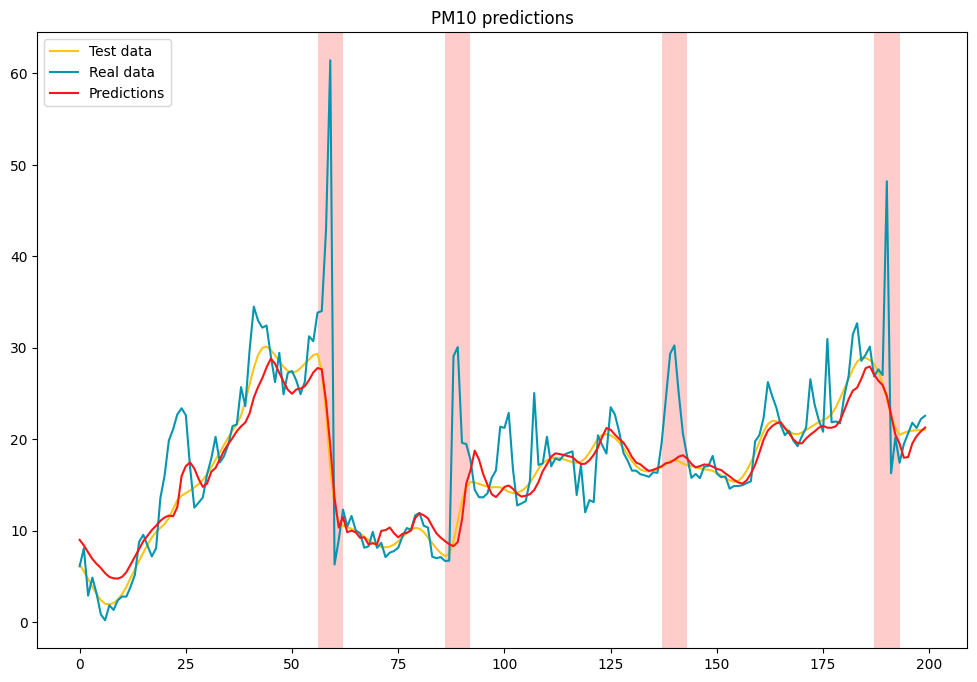

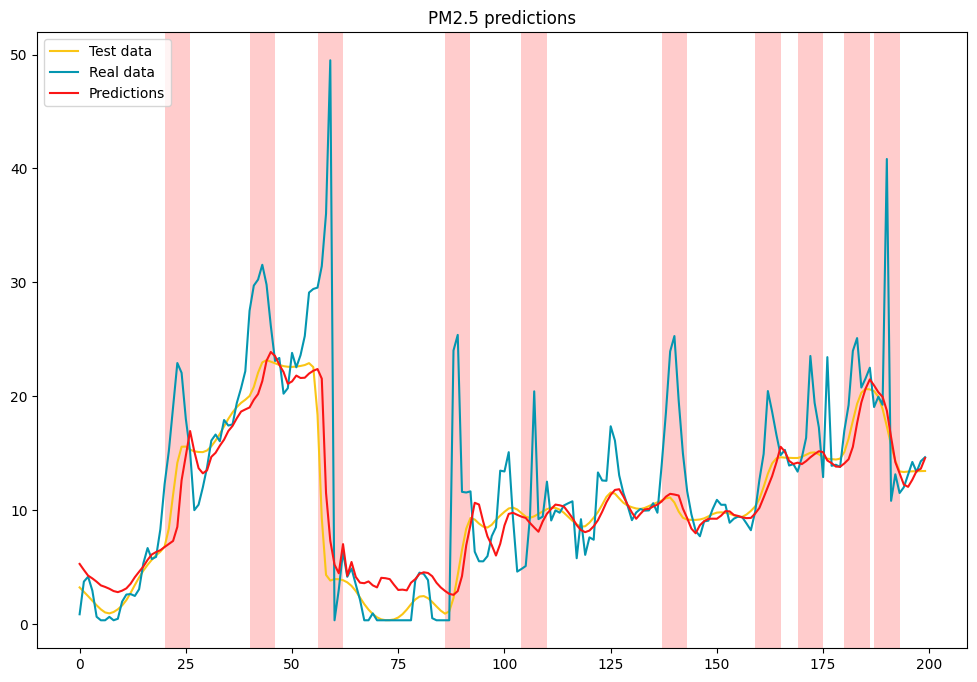

{'trend': {'MAPE': 0.33012654219696913,
  'RMSE': 5.714239315754507,
  'MAE': 3.206385504029882}}

In [32]:
model2_metrics['trend'] = plotAndEvaluateMultiHead(model2, trend_scaler, testX, real_data, test_data)
model2_metrics

### In: Trend + Seasonal (cleaned, normed)

In [33]:
testData = trend_seasonal[int(len(trend_seasonal)*0.8):]

testX = []
for i in range(nPastHours, len(testData)):
    testX.append(testData[i-nPastHours: i, :])

testX = np.array(testX)
print(f'testX shape: {testX.shape}')

testX shape: (5237, 24, 2)


In [34]:
testData = pd.DataFrame(testData)
testData = trend_seasonal_scaler.inverse_transform(testData)

7/7 [==============================] - 0s 2ms/step


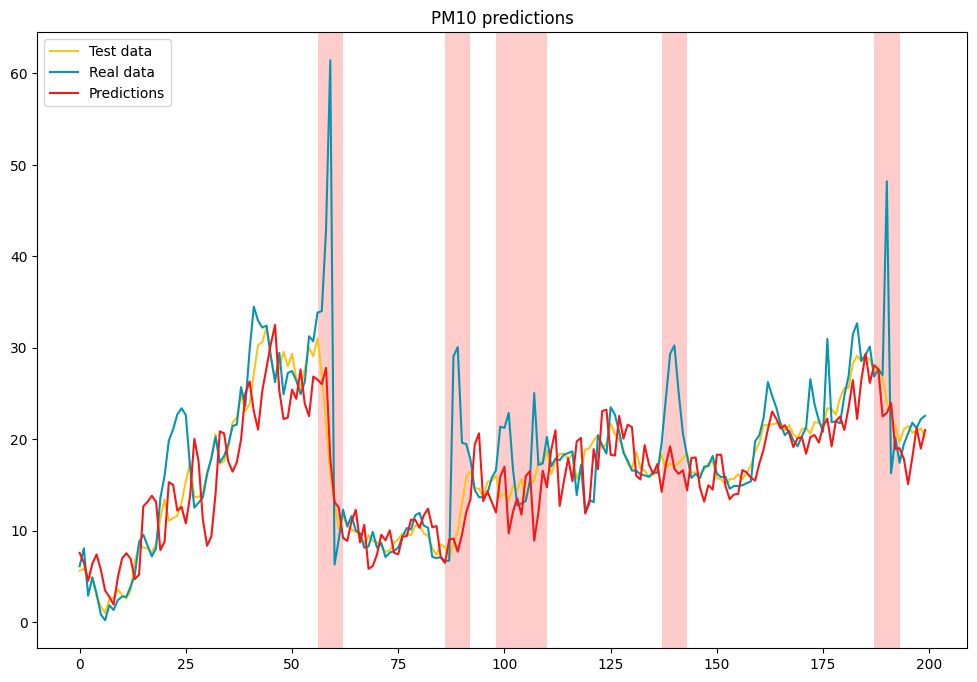

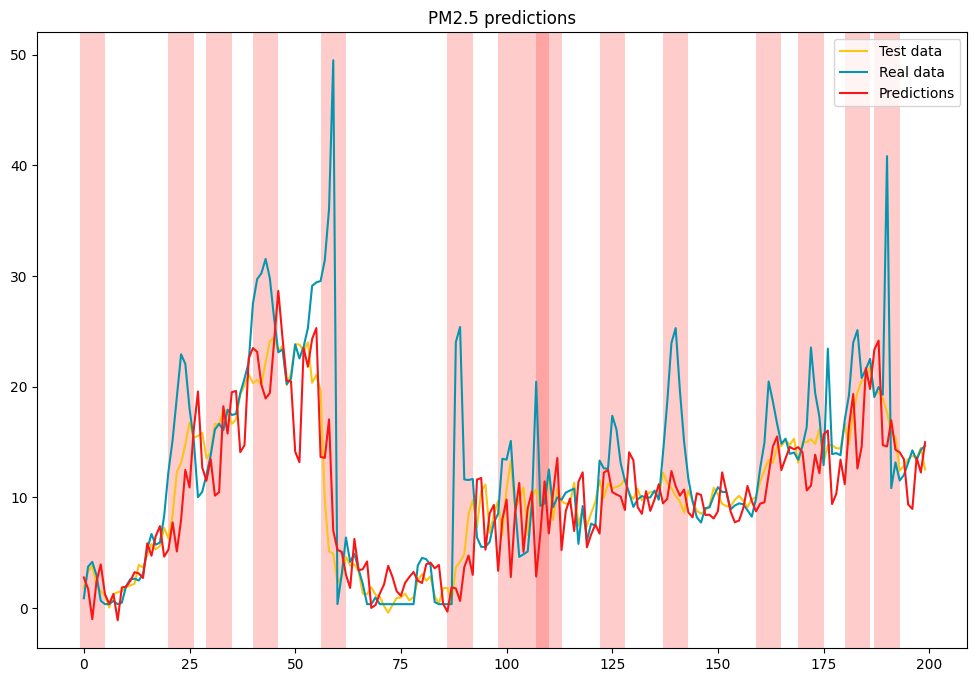

{'trend': {'MAPE': 0.33012654219696913,
  'RMSE': 5.714239315754507,
  'MAE': 3.206385504029882},
 'trend+seasonal': {'MAPE': 0.6514569529290108,
  'RMSE': 6.487523870120445,
  'MAE': 4.125801848397571}}

In [35]:
model2_metrics['trend+seasonal'] = plotAndEvaluateMultiHead(model2, trend_seasonal_scaler, testX, real_data, testData)
model2_metrics

## Comparison of models

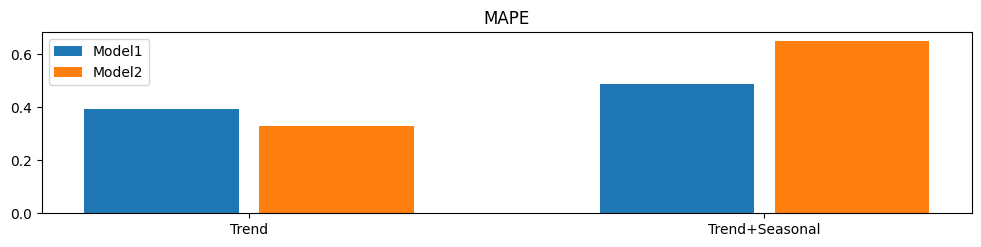

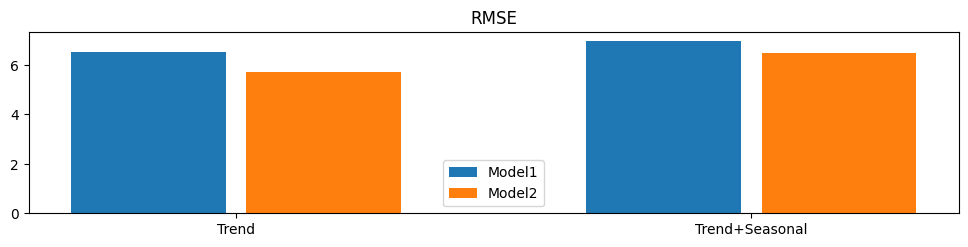

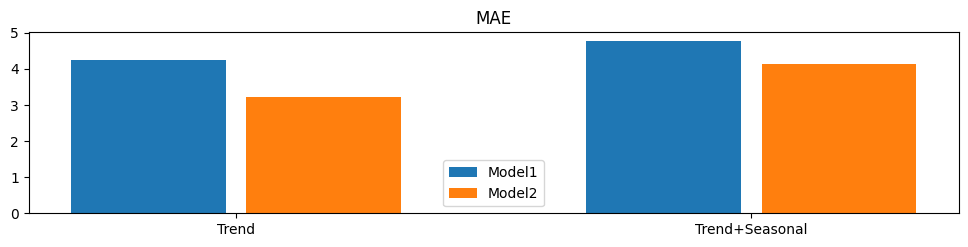

In [36]:
width = 0.3
plt.subplot(3, 1, 1)
arr1, arr2 = [], []
for x in ['trend', 'trend+seasonal']:
    arr1.append(model1_metrics[x]['MAPE'])
    arr2.append(model2_metrics[x]['MAPE'])
x = np.arange(len(arr1))
plt.title('MAPE')
plt.bar(x-0.17, arr1, width, label='Model1')
plt.bar(x+0.17, arr2, width, label='Model2')
plt.xticks(x, labels=['Trend', 'Trend+Seasonal'])
plt.legend()
plt.show()

plt.subplot(3, 1, 2)
arr1, arr2 = [], []
for x in ['trend', 'trend+seasonal']:
    arr1.append(model1_metrics[x]['RMSE'])
    arr2.append(model2_metrics[x]['RMSE'])
x = np.arange(len(arr1))
plt.title('RMSE')
plt.bar(x-0.17, arr1, width, label='Model1')
plt.bar(x+0.17, arr2, width, label='Model2')
plt.xticks(x, labels=['Trend', 'Trend+Seasonal'])
plt.legend()
plt.show()

plt.subplot(3, 1, 3)
arr1, arr2 = [], []
for x in ['trend', 'trend+seasonal']:
    arr1.append(model1_metrics[x]['MAE'])
    arr2.append(model2_metrics[x]['MAE'])
x = np.arange(len(arr1))
plt.title('MAE')
plt.bar(x-0.17, arr1, width, label='Model1')
plt.bar(x+0.17, arr2, width, label='Model2')
plt.xticks(x, labels=['Trend', 'Trend+Seasonal'])
plt.legend()
plt.show()